In [14]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
import csv
import time

Populating the interactive namespace from numpy and matplotlib


In [18]:
# -- Variable Dictionary --

# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Parameters we are trying to find
omega_m = None                  # mass density parameter
w = None                        # equation of state
dm_offset = None                # offset of the model from the data

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots
npts = None                     # Number of points (omega_m, w) we use

# Calculate Hubble distance
H = 70.0                        # Hubble constant
D_H = c / H                     # Hubble distance

# -------------------------------------------------------------------------------------------------------

# ----------------------------------- Function Dictionary -----------------------------------

# ----------------------------------- E(z) and DCDH integral -----------------------------------

# Calculate E(z), which in this situation depends on w
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    # Assume a flat universe, i.e. omega_k = 0
    omega_k = 0.0
    
    inside = omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1.0+w))
    
    if (inside < 0):
        print("inside = " + str(inside))
    inside = abs(inside)
    E = np.sqrt(inside)
    return E

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, w, omega_m, omega_l):
    
    f = lambda z_i: 1.0 / E(z_i, w, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

# -----------------------------------------------------------------------------------

# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, w, omega_m, omega_l):

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0

    # Calculate D_M/D_H for different universe geometries
    # open universe (omega_k > 0)
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z,w,omega_m,omega_l) )
    # closed universe (omega_k < 0)
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z,w,omega_m,omega_l) )
    # flat universe (omega_k = 0)
    else:
        return 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) )

# proper motion distance for omega_l != 0
def prop_motion(z, w, omega_m, omega_l):
        
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    # Continuing our flat universe assumption, we have
    omega_k = 0.0
    
    # Calculate D_C/D_H integral
    DCDH = DCDH_int(z,w,omega_m,omega_l)
    
    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        return 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH )
    # closed universe
    elif (omega_k < -1.0e-6):
        return 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH )
    # flat universe
    else:
        return DCDH

# --------------------------------------------------------------------------------------------

# distance modulus

def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    
    print("-------------------------")
    print("dist_mod:")
    print("z = " + str(z))
    print("D_H = " + str(D_H))
    print("omega_m" + str(omega_m))
    print("omega_l" + str(omega_l))
    
    # initialize the distance modulus value
    mu = 0.0
    
    # convert D_H from Mpc to pc
    DH = D_H * 1.0e6
    
    # Determine D_M/D_H
    if (omega_l == 0):
        DMDH = prop_motion_0(z, w, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, w, omega_m, omega_l)
    print("DMDH = " + str(DMDH))
    print("-------------------------")
    print()
    
    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    
    return mu

In [19]:
# Begin by collecting csv data and making a scatter plot of it
zs = []
dm_obs = []
sigmas = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
    i = 0
    for row in ps1_data:
        if (i > 0):
            zs.append(float(row[1]))
            dm_obs.append(float(row[4]))
            sigmas.append(float(row[5]))
        i+= 1
csvfile.close()
        
#plt.scatter(zs, dm_obs)
#print('z\tdm')
#for z, dm in zip(zs, dm_obs):
#    print('{:.3f}\t{:.3f}'.format(z, dm))

In [20]:
# -- Proposal and log likelihood functions defined --

# density function lnf(x) is the log likelihood of the data given parameters
# takes a vector x = (x1, x2, x3) as input
def make_log_likelihood(zs, dm_obs, sigmas, D_H):
    
    def log_likelihood(omega_m, w, dm_offset):
        
        # Assume a flat universe, i.e. omega_l = 1 - omega_m, or omega_k = 0
        omega_l = 1.0 - omega_m
                
        # initialize the log likelihood function
        ln_likelihood = 0.0

        # loop for all values of z in the z-array
        for i in range(len(zs)):
            
            # initialize for each iteration
            z_i = zs[i]
            sigma_dm_i = sigmas[i]
            dm_obs_i = dm_obs[i]
            
            # calculate predicted value of distance modulus based on z-value and parameters
            # predicted = [distance modulus calculation] + offset
            DMDH_i = prop_motion(z_i, w, omega_m, omega_l)    # proper motion distance
            dm_pred_i = dist_mod(z_i, D_H, omega_m, omega_l, DMDH_i) + dm_offset    # distance modulus

            # calculate each term
            term = np.log(1.0 / (sigma_dm_i*np.sqrt(2.0*np.pi))) \
            - 0.5 * (dm_obs_i-dm_pred_i) * (dm_obs_i-dm_pred_i) / (sigma_dm_i*sigma_dm_i)

            # increment log-likelihood
            ln_likelihood += term

            # print statement to debug code
            #print("x: " + str(xi) + " | sigma: " + str(sigma_i) + " | Term being added: " + str(term))
            
        return ln_likelihood
        
    return log_likelihood

# ------------------------------------ proposal function ------------------------------------

# proposal function q(x'|x) where x is a 3D vector. Proposal has a mean of x and each component has variance 1
def q(x, num_iter, zs, dm_obs, sigmas, D_H):
    
    # --------------------------------  Variables --------------------------------
    num_iter = num_iter         # num_iter = number of iterations
    vec_size = len(x)           # vec_size = size of each vector (number of dimensions)
    xchain = [None]*num_iter    # Initialize the Markov chain of x-vectors
        
    # propose num_iter matter density values (omega_m) in a uniform range 0 to 1
    # resulting in a chain of omega_m values of length num_iter
    omega_ms = np.random.uniform(-1.0,1.0,num_iter)
    
    w = 0.0                     # w, Initialize as 0
    dm_offset = 0.0             # distance modulus offset, Initialize as 0
    
    # temporary vectors for x
    old = x                     # old x-vector, initialized as x
    new = None                  # new x-vector
    
    # log-likelihood function
    lnf = make_log_likelihood(zs, dm_obs, sigmas, D_H)
    
    # -------------------------------- loop --------------------------------
    
    for i in range(num_iter):            # q is a 3D vector, so 3 components
        
        # initialize the "old" vector
        if (i > 0):
            old = xchain[i-1]
            
        # extract w and dm_offset variables from the old vector
        omega_m = old[0]
        w = old[1]
        dm_offset = old[2]
        
        # extract omega_m_new from the omega_ms chain
        omega_m_new = omega_ms[i]
        
        # propose w from a normal distribution with mean w (the old w) and variance 1
        mu = w
        sigma = 1.0
        w_new = np.random.normal(mu, sigma, 1)[0]
        
        # propose dm_offset from a normal distribution with mean dm_offset (the old value) and variance 1
        mu = dm_offset
        sigma = 1.0
        dm_offset_new = np.random.normal(mu, sigma, 1)[0]
        
        # generate each new entry of xchain. The components of each entry are as follows:
                    # omega_m component      w component  dm_offset component
        new = [omega_m_new,w_new,dm_offset_new]
        
        # Conditional statement: if lnfnew - lnfold > benchmark then tack on new value
        # otherwise, tack on old array copy the old value into the new value
        lnfnew = lnf(omega_m_new, w_new, dm_offset_new)
        lnfold = lnf(omega_m, w, dm_offset)
        benchmark = np.log(randn())
        
        #if (lnfnew - lnfold > benchmark):
        #    xchain.append(new)
        #else:
        #    xchain.append(old)
        
        # dummy statement, consider removing
        xchain[i] = new
        
        #omega_m_new = new[0]
        #w_new = new[1]
        #dm_offset_new = new[2]
        #if 

    return xchain

# test q

x = [1.0,1.0,1.0]    # seed vector
print("x before proposal: " + str(x))

# The Markov chain of x-vectors
xchain = q(x, 100, zs, dm_obs, sigmas, D_H)

# The final x-vector is the one we want
xfinal = xchain[-1]
print("xfinal = " + str(xfinal))

x before proposal: [1.0, 1.0, 1.0]
i = 0

omega_m = 1.0
w = 1.0
dm_offset = 1.0

omega_m_new = 0.6651269441020413
w_new = 0.0815231294350417
dm_offset_new = 0.5400713039367926

-------------------------
lnf:
omega_m = 0.6651269441020413
w = 0.0815231294350417
dm_offset = 0.5400713039367926
-------------------------

-------------------------
E(z):
z_i = 0.251545
w = 0.0815231294350417
omega_m0.6651269441020413
omega_l0.3348730558979587
inside = 1.9974078905482624
-------------------------

-------------------------
E(z):
z_i = 0.006563682284148026
w = 0.0815231294350417
omega_m0.6651269441020413
omega_l0.3348730558979587
inside = 1.0203674398751728
-------------------------

-------------------------
E(z):
z_i = 0.496526317715852
w = 0.0815231294350417
omega_m0.6651269441020413
omega_l0.3348730558979587
inside = 3.467908171283769
-------------------------

-------------------------
E(z):
z_i = 0.03394263542621939
w = 0.0815231294350417
omega_m0.6651269441020413
omega_l0.334873055897958

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'

In [13]:
# -- Run MCMC --

# Create the lnf function
lnf = make_log_likelihood(zs, dm_obs, sigmas, D_H)

# Markov chain
mchain = [[0.5,-1.0,20.0]]    # array of omega_m, w, and dm_offset values

for i in range(50):
    
    # Take the last entry in the Markov chain
    params = mchain[-1]
    
    omega_m = params[0]
    w = params[1]
    dm_offset = params[2]

    # propose a new point in the parameter space
    params_old = params.copy() # create a new array reference so that the old array reference doesn't get changed
    params_new = q(params_old)
    
    omega_m_new = params_new[0]
    w_new = params_new[1]
    dm_offset_new = params_new[2]
    
    print("i = " + str(i))
    print("params = " + str(params))
    print("params_new = " + str(params_new))
    print()
    
    #print("omega_m = " + str(omega_m) + " | w = " + str(w) + " | dm_offset = " + str(dm_offset))
    #print("omega_m_new = " + str(omega_m_new) + " | w_new = " + str(w_new) + " | dm_offset_new = " + str(dm_offset_new))
    #print()
    # log likelihood is always negative. If lnf_new is greater than lnf_old, then accept_diff is positive
    lnf_new = lnf(omega_m_new, w_new, dm_offset_new)
    lnf_old = lnf(omega_m, w, dm_offset)
    accept_diff = lnf_new - lnf_old
    #print("lnf old: " + str(lnf_old))
    #print("lnf new: " + str(lnf_new))
    #print("accept_diff = " + str(accept_diff))
    
    # accept if the accept_diff is greater than a randomly selected value from 1 to e, reject otherwise
    benchmark = np.log(rand())
    if benchmark < accept_diff:
        mchain.append(params_new)
    else:
        mchain.append(params)
    # Problem: At some point, it gets to where the acceptance difference is 
    
    #if (i % 20 == 0):
    #    print("i = " + str(i))
    
    # print a line to separate results of each iteration
    print()
    print("-----------")
    print()
        
print("Finished MCMC")

TypeError: q() missing 5 required positional arguments: 'num_iter', 'zs', 'dm_obs', 'sigmas', and 'D_H'

In [14]:
# Extract V- and R-coordinates from the array of vectors
omegams = []    # list of omega_m values
ws = []         # list of w values
offsets = []    # list of dm offsets

for i in mchain:
    omegams.append(i[0])
    ws.append(i[1])
    offsets.append(i[2])
    #print("length of each array: " + str(len(omegams)))
    # Variation of the loop: use an if statement to omit burn-in points
    #for i in VRs:
    #

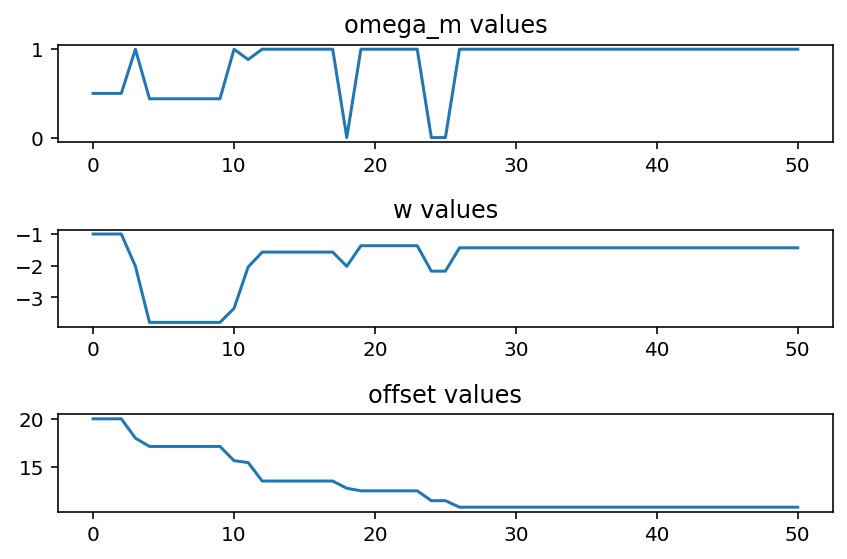

In [15]:
# Trace the evolution of V and R values over iterations
subplot(311)
title('omega_m values')
plot(omegams)

subplot(312)
title('w values')
plot(ws)

subplot(313)
title('offset values')
plot(offsets)

tight_layout()

show()

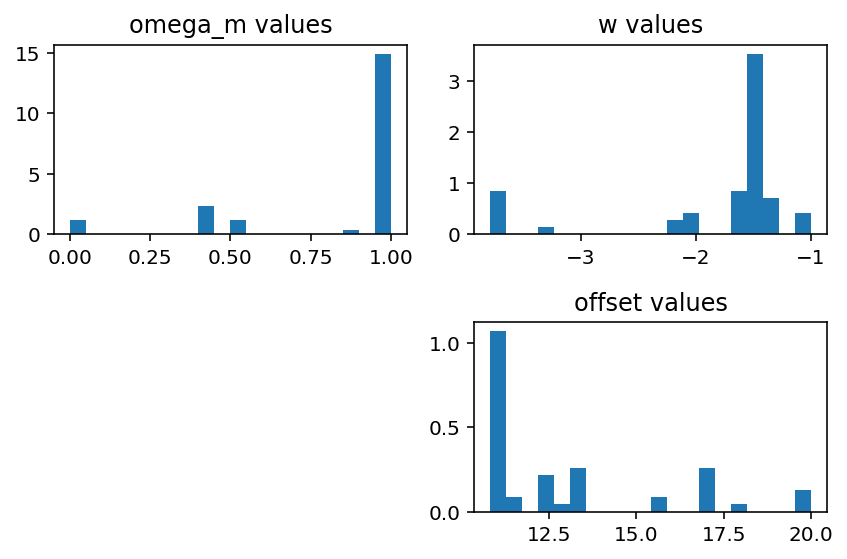

In [16]:
    
# Generate 1-dimensional histograms of parameter values
subplot(221)
title('omega_m values')
hist(omegams, density=True, bins=20)

subplot(222)
title('w values')
hist(ws, density=True, bins=20)

subplot(224)
title('offset values')
hist(offsets, density=True, bins=20)

#subplot(223)
#title('R vs V')
#scatter(Vs, Rs)
#plt.xlabel('V')
#plt.ylabel('R')

tight_layout()

show()